In [1]:
import warnings
warnings.filterwarnings("ignore")
from keras.engine.topology import Layer
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pandas as pd
# from tcn import TCN
%matplotlib inline
from keras.layers import merge, Input, Dense, TimeDistributed, Lambda                                   
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPooling2D,MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, GlobalAveragePooling2D,AveragePooling2D, Add
from keras.optimizers import Adam, rmsprop
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
MAX_SENT_LENGTH = 55
MAX_SENTS = 24
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from pandas import concat

std = StandardScaler()

mmstd = MinMaxScaler()

In [3]:
import pandas as pd
#matplotlib inline
#参数初始化
discfile = '../data/data_wea_time_unify.csv'

data = pd.read_csv(discfile)

In [4]:
futrue_time=24

time_step=24

In [5]:
# train:val:test=8:1:1
# 5969=4776:597:596

flag=5373
Data_num=5969

In [6]:
np.shape(data)

(6064, 76)

In [7]:
for i in range(24,96):
    data['PM25_m'+str(i)]=data['PM25_mean'].shift(-i)
data=data.dropna(how='any')

In [41]:
data.columns[4:58]

Index(['PM25_1', 'PM25_2', 'PM25_3', 'PM25_4', 'PM25_5', 'PM25_6', 'PM25_7',
       'PM25_8', 'PM25_9', 'PM10_1', 'PM10_2', 'PM10_3', 'PM10_4', 'PM10_5',
       'PM10_6', 'PM10_7', 'PM10_8', 'PM10_9', 'SO2_1', 'SO2_2', 'SO2_3',
       'SO2_4', 'SO2_5', 'SO2_6', 'SO2_7', 'SO2_8', 'SO2_9', 'NO2_1', 'NO2_2',
       'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO2_8', 'NO2_9', 'O3_1',
       'O3_2', 'O3_3', 'O3_4', 'O3_5', 'O3_6', 'O3_7', 'O3_8', 'O3_9', 'CO_1',
       'CO_2', 'CO_3', 'CO_4', 'CO_5', 'CO_6', 'CO_7', 'CO_8', 'CO_9'],
      dtype='object')

In [8]:
target_data=data.iloc[:,76:]
source_data=data.iloc[:,4:58]

import copy
sd=copy.deepcopy(source_data)
td=copy.deepcopy(target_data)

# td=td.dropna(how='any')
# td=std.fit_transform(td)
sd=mmstd.fit_transform(sd)
# sd=sd.values
td=td.values
td_test=td[flag+1:5969-23,:futrue_time]   
td=td[:flag+1,:futrue_time]
sd_m=[]
for i in range(1,MAX_SENTS+1):
    locals()['sd'+str(i)]=sd[i-1:flag+i]

    sd_m.append(locals()['sd'+str(i)])
sd_m=(np.array(sd_m).swapaxes(0,1))


######test
sd_m_test=[]
for i in range(1,25):
    locals()['sd_t'+str(i)]=sd[flag+i:5969-24+i]
    
    sd_m_test.append(locals()['sd_t'+str(i)])

sd_m_test=(np.array(sd_m_test).swapaxes(0,1))

In [9]:
np.shape(sd_m)

(5374, 24, 54)

In [10]:
np.shape(data[data.hour==0])

(252, 148)

In [14]:
Index_data=data[['date', 'hour', 'PM25_1']]

In [16]:
Index_data['index_']=range(5969)

In [38]:
sd_m[list(Index_data[Index_data.hour==0].index_)]

IndexError: index 5378 is out of bounds for axis 0 with size 5374

In [36]:
type(Index_data)

pandas.core.frame.DataFrame

In [39]:
data.columns


Index(['Unnamed: 0', 'Unnamed: 0.1', 'date', 'hour', 'PM25_1', 'PM25_2',
       'PM25_3', 'PM25_4', 'PM25_5', 'PM25_6',
       ...
       'PM25_m86', 'PM25_m87', 'PM25_m88', 'PM25_m89', 'PM25_m90', 'PM25_m91',
       'PM25_m92', 'PM25_m93', 'PM25_m94', 'PM25_m95'],
      dtype='object', length=148)

In [12]:
wea_data=data.iloc[:,67:75]
# wea_data=std.fit_transform(wea_data)
# wea_data=pd.DataFrame(wea_data)
w=wea_data[['Conditions','Wind Dir','Quality evaluation']]
# w=std.fit_transform(w)
w_m=[]
for i in range(1,25):
    locals()['w'+str(i)]=w[i-1:flag+i].values
    
    w_m.append(locals()['w'+str(i)])
    
wea=wea_data[['Dew Point','Humidity','Pressure','Temp.','Wind Speed']]
wea=std.fit_transform(wea)
wea_m=[]
for i in range(1,25):
    locals()['wea'+str(i)]=wea[i-1:flag+i]
    
    wea_m.append(locals()['wea'+str(i)])

In [13]:
time_data=data.iloc[:,64:67]
# time_data=std.fit_transform(time_data)
time_m=[]
for i in range(1,25):
    locals()['time'+str(i)]=time_data[i-1:flag+i].values
    
    time_m.append(locals()['time'+str(i)])

In [14]:
time_m=(np.array(time_m).swapaxes(0,1))
w_m=(np.array(w_m).swapaxes(0,1))
wea_m=(np.array(wea_m).swapaxes(0,1))

In [15]:
time_m_test=[]
for i in range(1,25):
    locals()['time_t'+str(i)]=time_data[flag+i:5969-24+i].values
    
    time_m_test.append(locals()['time_t'+str(i)])

time_m_test=(np.array(time_m_test).swapaxes(0,1))

w_m_test=[]
for i in range(1,25):
    locals()['w_t'+str(i)]=w[flag+i:5969-24+i].values
    
    w_m_test.append(locals()['w_t'+str(i)])

w_m_test=(np.array(w_m_test).swapaxes(0,1))

wea_m_test=[]
for i in range(1,25):
    locals()['wea_t'+str(i)]=wea[flag+i:5969-24+i]
    
    wea_m_test.append(locals()['wea_t'+str(i)])

wea_m_test=(np.array(wea_m_test).swapaxes(0,1))

In [17]:
import h5py
import os

ground = h5py.File('../data/inte_g_12_linear.h5', 'r')
g = ground['X']

ele_zs = h5py.File('../data/inte_e_zs_12_new_linear.h5', 'r')
ezs = ele_zs['X']

ele_sd = h5py.File('../data/inte_e_sd_12_new_linear.h5', 'r')
esd = ele_sd['X']

g_m=[]
for i in range(1,25):
    locals()['g'+str(i)]=g[i-1:flag+i]
    
    g_m.append(locals()['g'+str(i)])
g_m=(np.array(g_m).swapaxes(0,1))
g_m=g_m.reshape(flag+1, 24, 16,16,1)

ezs_m=[]
for i in range(1,25):
    locals()['ezs'+str(i)]=ezs[i-1:flag+i]
    
    ezs_m.append(locals()['ezs'+str(i)])
ezs_m=(np.array(ezs_m).swapaxes(0,1))

ezs_m=ezs_m.reshape(flag+1, 24, 16,16,1)

esd_m=[]
for i in range(1,25):
    locals()['esd'+str(i)]=esd[i-1:flag+i]
    
    esd_m.append(locals()['esd'+str(i)])
esd_m=(np.array(esd_m).swapaxes(0,1))

esd_m=esd_m.reshape(flag+1, 24, 16,16,1)

ge_m=[ezs_m,esd_m,g_m]

ge_m=np.array(ge_m).reshape(flag+1, 24, 16,16,3)

In [18]:
#####test
g_m_test=[]
for i in range(1,25):
    locals()['g_t'+str(i)]=g[flag+i:5969-24+i]
    
    g_m_test.append(locals()['g_t'+str(i)])
g_m_test=(np.array(g_m_test).swapaxes(0,1))

g_m_test=g_m_test.reshape(5969-24-flag, 24, 16,16,1)

ezs_m_test=[]
for i in range(1,25):
    locals()['ezs_t'+str(i)]=ezs[flag+i:5969-24+i]
    
    ezs_m_test.append(locals()['ezs_t'+str(i)])
ezs_m_test=(np.array(ezs_m_test).swapaxes(0,1))

ezs_m_test=ezs_m_test.reshape(5969-24-flag, 24, 16,16,1)

esd_m_test=[]
for i in range(1,25):
    locals()['esd_t'+str(i)]=esd[flag+i:5969-24+i]
    
    esd_m_test.append(locals()['esd_t'+str(i)])
esd_m_test=(np.array(esd_m_test).swapaxes(0,1))

esd_m_test=esd_m_test.reshape(5969-24-flag, 24, 16,16,1)
ge_m_test=[ezs_m_test,esd_m_test,g_m_test]

ge_m_test=np.array(ge_m_test).reshape(5969-24-flag, 24, 16,16,3)

In [19]:
sd_sum=np.append(sd_m,sd_m_test,axis=0)

In [20]:
ge_sum=np.append(ge_m,ge_m_test,axis=0)

In [21]:
wea_sum=np.append(wea_m,wea_m_test,axis=0)

In [22]:
w_sum=np.append(w_m,w_m_test,axis=0)

In [80]:
td_sum=np.append(td,td_test,axis=0)

In [84]:
np.shape(w_sum)

(5946, 24, 3)

In [82]:
5969-24-flag

572

In [14]:
from keras.layers import *
import keras.backend as K


def to_mask(x, mask, mode='mul'):
    """通用mask函数
    """
    if mask is None:
        return x
    else:
        for _ in range(K.ndim(x) - K.ndim(mask)):
            mask = K.expand_dims(mask, K.ndim(mask))
        if mode == 'mul':
            return x * mask
        else:
            return x - (1 - mask) * 1e10

class OurLayer(Layer):
    """定义新的Layer，增加reuse方法，允许在定义Layer时调用现成的层
    """
    def reuse(self, layer, *args, **kwargs):
        if not layer.built:
            if len(args) > 0:
                inputs = args[0]
            else:
                inputs = kwargs['inputs']
            if isinstance(inputs, list):
                input_shape = [K.int_shape(x) for x in inputs]
            else:
                input_shape = K.int_shape(inputs)
            layer.build(input_shape)
        outputs = layer.call(*args, **kwargs)
        for w in layer.trainable_weights:
            if w not in self._trainable_weights:
                self._trainable_weights.append(w)
        for w in layer.non_trainable_weights:
            if w not in self._non_trainable_weights:
                self._non_trainable_weights.append(w)
        return outputs
class MAttention(OurLayer):
    """多头注意力机制
    """
    def __init__(self, heads=8, size_per_head=16, key_size=None,
                 mask_right=False, **kwargs):
        super(MAttention, self).__init__(**kwargs)
        self.heads = heads
        self.size_per_head = size_per_head
        self.out_dim = heads * size_per_head
        self.key_size = key_size if key_size else size_per_head
        self.mask_right = mask_right
    def build(self, input_shape):
        super(MAttention, self).build(input_shape)
        self.q_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.k_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.v_dense = Dense(self.out_dim, use_bias=False)
    def get_config(self):
        config = {'heads': self.heads,'size_per_head': self.size_per_head}
        base_config = super(MAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        q, k, v = inputs[: 3]
        v_mask, q_mask = None, None
        if len(inputs) > 3:
            v_mask = inputs[3]
            if len(inputs) > 4:
                q_mask = inputs[4]
        # 线性变换
        qw = self.reuse(self.q_dense, q)
        kw = self.reuse(self.k_dense, k)
        vw = self.reuse(self.v_dense, v)
        # 形状变换
        qw = K.reshape(qw, (-1, K.shape(qw)[1], self.heads, self.key_size))
        kw = K.reshape(kw, (-1, K.shape(kw)[1], self.heads, self.key_size))
        vw = K.reshape(vw, (-1, K.shape(vw)[1], self.heads, self.size_per_head))
        # 维度置换
        qw = K.permute_dimensions(qw, (0, 2, 1, 3))
        kw = K.permute_dimensions(kw, (0, 2, 1, 3))
        vw = K.permute_dimensions(vw, (0, 2, 1, 3))
        # Attention
        a = K.batch_dot(qw, kw, [3, 3]) / self.key_size**0.5
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        a = to_mask(a, v_mask, 'add')
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        if (self.mask_right is not False) or (self.mask_right is not None):
            if self.mask_right is True:
                ones = K.ones_like(a[: 1, : 1])
                mask = (ones - K.tf.matrix_band_part(ones, -1, 0)) * 1e10
                a = a - mask
            else:
                # 这种情况下，mask_right是外部传入的0/1矩阵，shape=[q_len, k_len]
                mask = (1 - K.constant(self.mask_right)) * 1e10
                mask = K.expand_dims(K.expand_dims(mask, 0), 0)
                self.mask = mask
                a = a - mask
        a = K.softmax(a)
        self.a = a
        # 完成输出
        o = K.batch_dot(a, vw, [3, 2])
        o = K.permute_dimensions(o, (0, 2, 1, 3))
        o = K.reshape(o, (-1, K.shape(o)[1], self.out_dim))
        o = to_mask(o, q_mask, 'mul')
        return o
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.out_dim)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(** kwargs)
    
    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        # general
        a = K.softmax(K.tanh(K.dot(x, self.W)))
        a = K.permute_dimensions(a, (0, 2, 1))
        outputs = a * inputs
        outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]
    
from keras.models import load_model
from attention_keras import *
model = load_model('new_LRP_norm03_model_17.455_22.708new_At_TCNkeyong.h5',custom_objects={'MAttention': MAttention,'AttentionLayer':AttentionLayer})

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_124 (InputLayer)          (None, 24, 16, 16, 3 0                                            
__________________________________________________________________________________________________
time_distributed_79 (TimeDistri (None, 24, 3)        175         input_124[0][0]                  
__________________________________________________________________________________________________
input_123 (InputLayer)          (None, 24, 54)       0                                            
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 24, 57)       0           time_distributed_79[0][0]        
                                                                 input_123[0][0]                  
__________

In [ ]:
pre_test=model.predict([w_m_test,wea_m_test,ge_m_test,sd_m_test])

import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(np.round(mean_absolute_error(pre_test,td_test[:145]),3),np.round(np.sqrt(mean_squared_error(pre_test,td_test[:145])),3))
# mean_absolute_error(pre_test,td_test[:145]),np.sqrt(mean_squared_error(pre_test,td_test[:145]))


In [16]:
import innvestigate

In [1]:
analyzer = innvestigate.create_analyzer("gradient", model, allow_lambda_layers = True)
# analyzer = innvestigate.create_analyzer("lrp.z", model, allow_lambda_layers = True)

NameError: name 'innvestigate' is not defined

In [36]:
analyzer

In [17]:
sd_sum=np.append(sd_m,sd_m_test,axis=0)

In [18]:
ge_sum=np.append(ge_m,ge_m_test,axis=0)

In [19]:
wea_sum=np.append(wea_m,wea_m_test,axis=0)

In [20]:
w_sum=np.append(w_m,w_m_test,axis=0)

In [21]:
td_sum=np.append(td,td_test[:145],axis=0)

In [22]:
tem1=w_sum
tem2=wea_sum
tem3=ge_sum
tem4=sd_sum

In [160]:
# tem2=time_m[0].reshape(1,24, 3)
# tem1=w_m[0].reshape(1,24, 3)
# tem2=wea_m[0].reshape(1,24,5)
# tem3=ge_m[0].reshape(1,24, 16, 16, 3)
# tem4=sd_m[0].reshape(1,24,54)

In [161]:
# analysis = analyzer.analyze([tem2,tem3,tem4,tem1,tem])
analysis = analyzer.analyze([tem1,tem2,tem3,tem4])


In [162]:
a=analysis[0]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))

In [163]:
np.shape(a)

(1, 24)

In [165]:
from IPython.display import display, HTML
from heatmap import html_heatmap

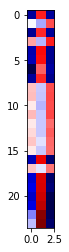

In [167]:
a0=analysis[0]
a0 = a0.sum(axis=np.argmax(np.asarray(a0.shape) == 1))
a0 /= np.max(np.abs(a0),axis=0)
plt.imshow(a0, cmap="seismic", clim=(-1, 1))

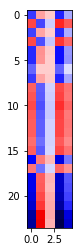

In [169]:
a1=analysis[1]
a1 = a1.sum(axis=np.argmax(np.asarray(a1.shape) == 3))
a1 /= np.max(np.abs(a1))
plt.imshow(a1, cmap="seismic", clim=(-1, 1))

In [177]:
temp=analysis[2].sum(axis=np.argmax(np.asarray(analysis[2].shape) == 24))/ np.max(np.abs(analysis[2]))
# np.shape(temp[0].reshape( 3,16, 16)[0])
np.shape(temp[0])

(16, 16, 3)

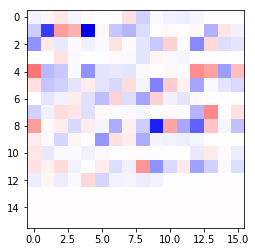

In [180]:
a2=analysis[2]
a2 = a2.sum(axis=np.argmax(np.asarray(a2.shape) == 3))
a2 /= np.max(np.abs(a2))
plt.imshow(temp[0].reshape( 3,16, 16)[2], cmap="seismic", clim=(-1, 1))

In [170]:
a3=analysis[2]
a3 = a3.sum(axis=np.argmax(np.asarray(a3.shape) == 3))
a3 /= np.max(np.abs(a3))

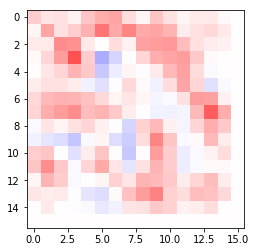

In [175]:
plt.imshow(a3[0][23], cmap="seismic", clim=(-1, 1))

In [235]:
np.shape(ge_m[0][0])
aaaa=tem1[0][0]
aaaa /= np.max(np.abs(tem1[0][0]))

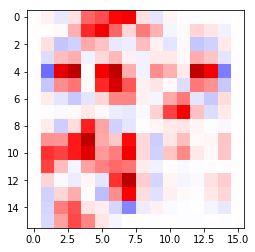

In [236]:
plt.imshow(aaaa.reshape( 3,16, 16)[0], cmap="seismic", clim=(-1, 1))

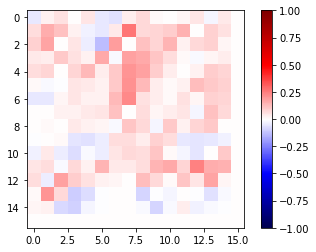

In [148]:
a3=analysis[2]
a3 = a3.sum(axis=np.argmax(np.asarray(a3.shape) == 3))
a3 /= np.max(np.abs(a3))
# plt.imshow(a3, cmap="seismic", clim=(-1, 1))
# for i in range(24):
plt.imshow(a3[0][21], cmap="seismic", clim=(-1, 1))
plt.colorbar()
plt.show()

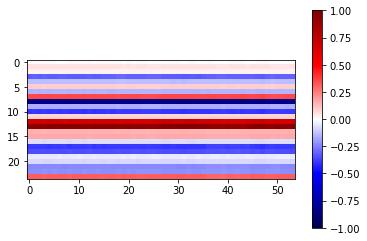

In [181]:
a4=analysis[3]
a4 = a4.sum(axis=np.argmax(np.asarray(a4.shape) == 3))
a4 /= np.max(np.abs(a4))
plt.imshow(a4, cmap="seismic", clim=(-1, 1))
plt.colorbar()
plt.show()
# for j in range(24):
#     display(HTML(html_heatmap([str(i) for i in range(54)], a4[j])))


In [82]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

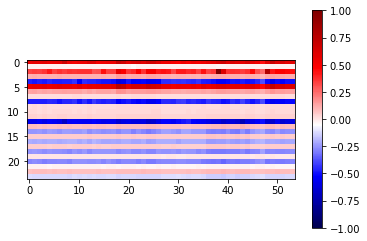

In [91]:
elev_min=-1
elev_max=1
mid_val=-0.05
cmap=matplotlib.cm.RdBu_r # set the colormap to soemthing diverging
plt.imshow(a4, cmap="seismic", clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar()
plt.show()

## 春(4965-5946)

 四季	      Spring	      Summer	     Autumn	        Winter
 
起始日期	2015年3月13日	2014年8月1日	2014年10月4日	2014年12月1日

终止日期	2015年4月30日	2014年10月3日	2014年11月30日	2015年3月12日

In [89]:
pre_Spring=model.predict([w_sum[4965:],wea_sum[4965:],ge_sum[4965:],sd_sum[4965:]])
# [w_m,wea_m,ge_m,sd_m]

In [96]:
np.shape(pre_Spring)

(981, 24)

In [118]:
np.shape(np.sum(td_sum[4965:],axis=1)/24)

(981,)

In [123]:
pd.DataFrame(pre_Spring).to_csv('spring_pre.csv')

In [124]:
pd.DataFrame(td_sum[4965:]).to_csv('spring_true.csv')

## 夏天(0-1347)

In [126]:
pre_Summer=model.predict([w_sum[0:1347],wea_sum[0:1347],ge_sum[0:1347],sd_sum[0:1347]])

In [128]:
pd.DataFrame(pre_Summer).to_csv('Summer_pre.csv')
pd.DataFrame(td_sum[0:1347]).to_csv('Summer_true.csv')

## 秋天（1348-2691）

In [129]:
pre_Autumn=model.predict([w_sum[1348:2691],wea_sum[1348:2691],ge_sum[1348:2691],sd_sum[1348:2691]])

In [131]:
pd.DataFrame(pre_Autumn).to_csv('Autumn_pre.csv')
pd.DataFrame(td_sum[1348:2691]).to_csv('Autumn_true.csv')

## Winter（2692-4964）

In [132]:
pre_Winter=model.predict([w_sum[2692:4964],wea_sum[2692:4964],ge_sum[2692:4964],sd_sum[2692:4964]])

In [134]:
pd.DataFrame(pre_Winter).to_csv('Winter_pre.csv')
pd.DataFrame(td_sum[2692:4964]).to_csv('Winter_true.csv')

## 保存模型（但是由于自定义层自带的参数问题，不能加载处理）

In [176]:
from keras.models import load_model

model.save('new_LRP_norm03_model_17.455_22.708new_At_TCNkeyong.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
# model = load_model('air_traff_model.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [13]:
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple


def channel_normalization(x):
    # type: (Layer) -> Layer
    """ Normalize a layer to the maximum activation

    This keeps a layers values between zero and one.
    It helps with relu's unbounded activation

    Args:
        x: The layer to normalize

    Returns:
        A maximal normalized layer
    """
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def wave_net_activation(x):
    # type: (Layer) -> Layer
    """This method defines the activation used for WaveNet

    described in https://deepmind.com/blog/wavenet-generative-model-raw-audio/

    Args:
        x: The layer we want to apply the activation to

    Returns:
        A new layer with the wavenet activation applied
    """
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)
    return keras.layers.multiply([tanh_out, sigm_out])


def residual_block(x, s, i, c, activation, nb_filters, kernel_size, padding, dropout_rate=0):
    # type: (Layer, int, int, int, str, int, int, str, float, str) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        s: The stack index i.e. which stack in the overall TCN
        i: The dilation power of 2 we are using for this residual block
        c: The dilation name to make it unique. In case we have same dilation twice: [1, 1, 2, 4].
        activation: The name of the type of activation to use
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """

    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding)(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    elif activation == 'wavenet':
        x = wave_net_activation(conv)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate)(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN:
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            activation: The activations to use (norm_relu, wavenet, relu...).
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True):
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                x, skip_out = residual_block(x, s, d, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 activation='norm_relu',  # type: str
                 padding='causal',  # type: str
                 use_skip_connections=True,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 ):
    # type: (...) -> keras.Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).

    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        activation: The activations to use.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A compiled keras TCN.
    """

    dilations = process_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, activation,
            padding, use_skip_connections, dropout_rate, return_sequences)(input_layer)

    print('x.shape=', x.shape)

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO To remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss='sparse_categorical_crossentropy', metrics=[accuracy])
        print('Adam with norm clipping.')
    else:
        # regression
        x = Dense(1)(x)
        x = Activation('linear')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)
        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss='mean_squared_error')

    return model


In [149]:
from keras.layers import *
import keras.backend as K


def to_mask(x, mask, mode='mul'):
    """通用mask函数
    """
    if mask is None:
        return x
    else:
        for _ in range(K.ndim(x) - K.ndim(mask)):
            mask = K.expand_dims(mask, K.ndim(mask))
        if mode == 'mul':
            return x * mask
        else:
            return x - (1 - mask) * 1e10

class OurLayer(Layer):
    """定义新的Layer，增加reuse方法，允许在定义Layer时调用现成的层
    """
    def reuse(self, layer, *args, **kwargs):
        if not layer.built:
            if len(args) > 0:
                inputs = args[0]
            else:
                inputs = kwargs['inputs']
            if isinstance(inputs, list):
                input_shape = [K.int_shape(x) for x in inputs]
            else:
                input_shape = K.int_shape(inputs)
            layer.build(input_shape)
        outputs = layer.call(*args, **kwargs)
        for w in layer.trainable_weights:
            if w not in self._trainable_weights:
                self._trainable_weights.append(w)
        for w in layer.non_trainable_weights:
            if w not in self._non_trainable_weights:
                self._non_trainable_weights.append(w)
        return outputs
class MAttention(OurLayer):
    """多头注意力机制
    """
    def __init__(self, heads=8, size_per_head=16, key_size=None,
                 mask_right=False, **kwargs):
        super(MAttention, self).__init__(**kwargs)
        self.heads = heads
        self.size_per_head = size_per_head
        self.out_dim = heads * size_per_head
        self.key_size = key_size if key_size else size_per_head
        self.mask_right = mask_right
    def build(self, input_shape):
        super(MAttention, self).build(input_shape)
        self.q_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.k_dense = Dense(self.key_size * self.heads, use_bias=False)
        self.v_dense = Dense(self.out_dim, use_bias=False)
    def get_config(self):
        config = {'heads': self.heads,'size_per_head': self.size_per_head}
        base_config = super(MAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        q, k, v = inputs[: 3]
        v_mask, q_mask = None, None
        if len(inputs) > 3:
            v_mask = inputs[3]
            if len(inputs) > 4:
                q_mask = inputs[4]
        # 线性变换
        qw = self.reuse(self.q_dense, q)
        kw = self.reuse(self.k_dense, k)
        vw = self.reuse(self.v_dense, v)
        # 形状变换
        qw = K.reshape(qw, (-1, K.shape(qw)[1], self.heads, self.key_size))
        kw = K.reshape(kw, (-1, K.shape(kw)[1], self.heads, self.key_size))
        vw = K.reshape(vw, (-1, K.shape(vw)[1], self.heads, self.size_per_head))
        # 维度置换
        qw = K.permute_dimensions(qw, (0, 2, 1, 3))
        kw = K.permute_dimensions(kw, (0, 2, 1, 3))
        vw = K.permute_dimensions(vw, (0, 2, 1, 3))
        # Attention
        a = K.batch_dot(qw, kw, [3, 3]) / self.key_size**0.5
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        a = to_mask(a, v_mask, 'add')
        a = K.permute_dimensions(a, (0, 3, 2, 1))
        if (self.mask_right is not False) or (self.mask_right is not None):
            if self.mask_right is True:
                ones = K.ones_like(a[: 1, : 1])
                mask = (ones - K.tf.matrix_band_part(ones, -1, 0)) * 1e10
                a = a - mask
            else:
                # 这种情况下，mask_right是外部传入的0/1矩阵，shape=[q_len, k_len]
                mask = (1 - K.constant(self.mask_right)) * 1e10
                mask = K.expand_dims(K.expand_dims(mask, 0), 0)
                self.mask = mask
                a = a - mask
        a = K.softmax(a)
        self.a = a
        # 完成输出
        o = K.batch_dot(a, vw, [3, 2])
        o = K.permute_dimensions(o, (0, 2, 1, 3))
        o = K.reshape(o, (-1, K.shape(o)[1], self.out_dim))
        o = to_mask(o, q_mask, 'mul')
        return o
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.out_dim)
